# Variational Quantum Eigensolver Tutorial

The VQE is a hybrid classical - quantum algorithm that attempts to find the ground state energy of some molecule. The VQE is a hybrid classical - quantum algorithm that attempts to find the ground state energy of some molecule. 

In [156]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, transpile
from qiskit.quantum_info import Statevector
from colorama import Fore, Back, Style

# 1 - <i>Writing the Hamiltonian in the computational basis<i>
In quantum mechanics, the Hamiltonian of a system is an operator corresponding to the total energy of that system, including both kinetic energy and potential energy.

In [164]:
# Defining our usual quantum gates as matrices

#========= Single Qubit Gates ==========

# Identity
I = np.array([[1,0],
              [0,1]])

# Not Gate
X = np.array([[0,1],
              [1,0]])

# Y Gate
Y = np.array([[0,-1j],
              [1j,0]])

# Z Gate
Z = np.array([[1,0],
              [0,-1]])

#========= Double Qubit Gates ==========
# (x) = Tensor Product symbol

II = np.kron(I,I) # I0 (x) I1 Gate
# Z0 = np.kron(I,Z) # I0 (x) Z1 Gate
Z0 = np.kron(Z,I) # I0 (x) Z1 Gate
# Z1 = np.kron(Z,I) # Z0 (x) I1 Gate
Z1 = np.kron(I,Z) # I0 (x) Z1 Gate
ZZ = np.kron(Z,Z) # Z0 (x) Z1 Gate
YY = np.kron(Y,Y) # Y0 (x) Y2 Gate
XX = np.kron(X,X) # X0 (x) X1 Gate
XY = np.kron(X,Y) # X0 (x) Y1 Gate

# These double qubit gates will be useful later on!

### We'll define the following:
<ul>
    <li> The true value of the ground state enerygy of <i>H<sub>2</sub></i>
    <li> Hamiltonian of <i>H<sub>2</sub></i> written in the computational basis and in terms of the Hartree-Fock 'g' cofficients
        <ul>
            <li> $ H_{mol} = g_{0}I_{0}I_{1} + g_{1}Z_{0} + g_{2}Z_{1} + g_{3}Z_{0}Z_{1} + g_{4}Y_{0}Y_{1} + g_{5}X_{0}X_{1} $
     <li> The nucler repulsion (electrostatic) energhy of $ H_{2} $
</ul>

In [165]:
# 1) True Ground State Energy of H_2
ground_state_true = -1.1457417

# 2) 'g' Coefficients
g0 = -0.4804
g1 =  0.3435
g2 = -0.4347
g3 =  0.5716
g4 =  0.0910
g5 =  0.0910

# Writing Halmiltonian of H_2 in commputational basis
Hmol = g0*II + g1*Z0 + g2*Z1 + g3*ZZ + g4*YY + g5*XX
print(Back.RED + '____Molecule Hamiltonian____' + Style.RESET_ALL)
print(Hmol)

#3) Nuclear Repulsion Energy.  This is just the energy due to the coloumb interactions in H_2
nuclear_repulsion = 0.7055696146

____Molecule Hamiltonian____
[[ 1.11022302e-16+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -2.73800000e-01+0.j  1.82000000e-01+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  1.82000000e-01+0.j -1.83020000e+00+0.j
   0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   1.82400000e-01+0.j]]


### Calculating the ground state Energy of H<sub>2</sub> using linear algebra methods 

Ground State Energy = min(Energy Eigenvalue) + Nuclear Repulsion Energy

$
E_{ground} = min(\{E\}) + U_{nuclear}
$



In [166]:
# Linear ALgebra Diagonalization Approach for finding the Ground State of H2

electronic_energy = min(np.linalg.eigvalsh(Hmol)) #lowest energy eigenvalue
ground_state = electronic_energy + nuclear_repulsion #calculating ground state energy

print(Back.RED + 'calculated ground state = ' + Style.RESET_ALL, ground_state)
print(Back.RED + 'true ground state =       ' + Style.RESET_ALL, ground_state_true)

calculated ground state =  -1.1456295095236442
true ground state =        -1.1457417


### <i><mark>Let's see how we can transform this into quanutm algorithm to AVOIDE using classical diagonalization techniques</mark></i>
The Energy expectation value of any Fermion-based quanutm system will be greater than or equal to it's ground state energy. Or, in mathematical language,

$
  < \psi |E| \psi> \ge E_{ground}
$

The goal of the VQE is to minimize the energy expectation value in order to approximate the ground state energy. But we cannot commpute the epectation value without a wavefunction, and we can't solve for the wavefunction of $H_{2}$.

<mark >We propose a wave function of ansatz. </mark>

In perticular, [1] proposes a wavefunction ansatz in terms of a unitary ansatz $\mathscr{U}$

$|\psi> = \mathscr{U}|01>$ , where [1] chooses the unitary ansatz to be <i>Unitary coupled clusters </i>

$\mathscr{U} = \exp(-{i}\theta X \otimes Y)$

where $\theta$ is some tunable parameter to minimize energy expectation value

### Defining the Unitary ansatz and an Expection Value Function

In [167]:
# Building a Unitary ansatz to act on |01>, so we can compute energy expectation values

# |01> State as a column vector [0, 1, 0, 0] 
state_01 = np.array([[0], [1], [0], [0]])

# unitary ansatz as an exponential matrix
def ansatz(theta):
    return expm(-1j*theta*XY)

# a function that computes energy expectation values
def expected(theta, H):
    a = ansatz(theta) @ state_01
    a_dag = np.conjugate(np.transpose(a))
    ans = a_dag @ H @ a
    return np.real(ans)[0][0]

### Computing and minimizing $ <E> $
The quantum part of the VQE computes energy expectation values, while the classical part minimizes them. Now that we have a function called <i> expected </i> that computes expectation values based on a given Hamiltonian and a value of $ \theta $, let's plot $ <E> $ as a function of $ \theta $ to visually see which values of $ \theta $ minimize $ <E> $

min theta:  ----------->  4.598108505824718
min <E>:    ----------->  -1.8511985651124223
ground state energy: -->  -1.1456289505124224


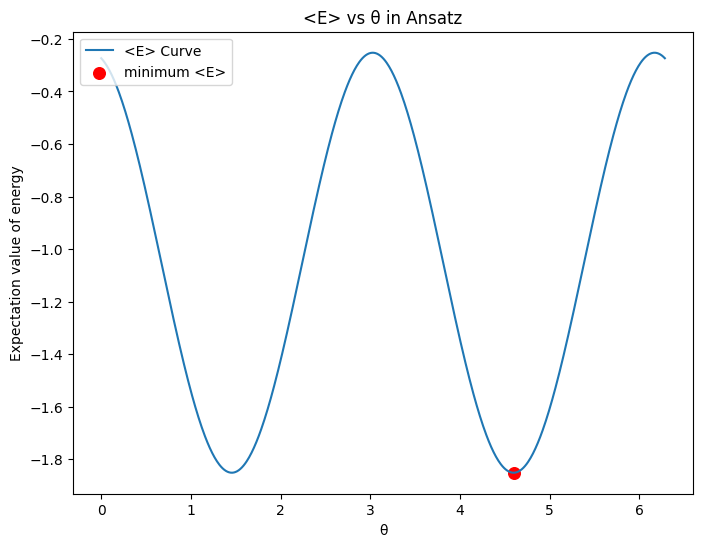

In [168]:
# Doing a scan of theta from 0-> 2pi and computing <E> at each step


#========================= Computing <E> at each theta value ===========================
theta_arr = np.linspace(0,2*np.pi,702)
E_arr = []
for i in range(len(theta_arr)):
    E_arr.append(expected(theta_arr[i], Hmol))
    

#====================== Finding which theta yields a minimum <E> =======================
theta_min = theta_arr[np.argmin(E_arr)]
E_min = min(E_arr)
ground_state = E_min + nuclear_repulsion

print(Back.RED + 'min theta:' + Style.RESET_ALL + '  -----------> ', theta_min)
print(Back.RED + 'min <E>:' + Style.RESET_ALL,  '   -----------> ', E_min)
print(Back.RED + 'ground state energy:'+Style.RESET_ALL,'--> ', ground_state)

#plotting <E> as a function of theta
plt.figure(figsize = (8, 6))
plt.title('<E> vs \u03B8 in Ansatz')
plt.xlabel('\u03B8')
plt.ylabel('Expectation value of energy')
plt.plot(theta_arr, E_arr, label = '<E> Curve')
plt.scatter([theta_min], [E_min], s = 70, c = 'r', label = 'minimum <E>')
plt.legend(loc = 'upper left')
plt.show()

The visual interpretation shows that $\theta = $ 4.596364251700976 yields the minimum $<E>$

From here we can calculate the ground state energy with $E_{ground} = min(\{E\}) + U_{nuclear}$

But wait, $min(\{E\})$ is the minimum energy eigenvalue, and we don't have that. But we do have $<E>$ AND we know that $<E> \geq min(\{E\})$.

Thus, if we minimize $<E> \rightarrow <E>_{min}$, then $<E>_{min} \approx min(\{E\})$. <mark> This is the crux of VQE </mark>

Therefore,

$E_{ground} \approx <E>_{min} + U_{nuclear}$

$E_{ground} \approx (-1.85119) + (0.70556)$

$E_{ground} \approx -1.14563$

The true ground state energy is $-1.1457417$....Not bad!

# <i> Constructing a Quanutm Circuit for VQE </i>

So far, we have not implimented VQE on an actual quantum circuit. This is an essential step since we need to map VQE to a quantum circuit so we can build an actual quantum algorithm.

Represent the unitary ansatz as a quanutm circuit. <mark> Any unitary gate can be built out of other unitary gates</mark>. Thus in theory we shiuld be able to build $\mathscr{U}$ using quantum gates, since other than measurement gates all quanutm gate sare unitary.

According to [1], below is the circuit for $\mathscr{U}$ 

<img src="download.png"/>

### Implementing VQE in Qiskit

In [170]:
def ReturnPsi(obj, **kwargs):
    '''
    Returns the wavefunction psi in a numpy array
    '''

    if(type(obj) == QuantumCircuit  ):
        statevec = execute( obj, S_simulator, shots=1 ).result().get_statevector()
    if(type(obj) == np.ndarray):
        statevec = obj
    #==============
    statevec = list( np.asarray(statevec) )
    #==============
    dec = 5
    if 'precision' in kwargs:
        dec = int( kwargs['precision'] )
           
    # Rounding off states
    statevec = np.round(statevec,dec) 
    num_bases = len(statevec)
    num_qubits = int(np.log2(num_bases))
    
    
    def bin_gen(number, num_qubits):
        bin1 = bin(number)[2:]
        L = num_qubits - len(bin1)
        bin2 = L*'0' + bin1
        return bin2
    
    def rev_bin_gen(number, num_qubits):
        return bin_gen(number, num_qubits)[::-1]
    
    def binto10(number):
        num_qubits = len(number)
        num_bases  = int(2**num_qubits)
        reg_order = []
        for i in range(num_bases):
            reg_order.append(bin_gen(i, num_qubits))
            
        reg_order = np.array(reg_order)
        return np.where(reg_order == number)[0][0]
    
    def dual_sort(key, values):
        k=1
        while k!=0:
            k=0
            for i in range(len(key)-1):
                a = key[i]
                b = key[i+1]

                c = values[i]
                d = values[i+1]

                if b<a:
                    k+=1
                    key[i] = b
                    key[i+1] = a

                    values[i] = d
                    values[i+1] = c
                    
                    
        return values
    
    key = []
    for i in range(num_bases):
        key.append(binto10(rev_bin_gen(i, num_qubits)))
        
    psi = dual_sort(key, statevec)
    
    return psi

In [175]:
# setting up quanutm register
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q,c)

#state preparation
qc.x(q[1])
qc.barrier()

#encoding unitary ansatz
def ansatz_circ(qc, theta):
    '''
    append ansatz quantum circuit equivalent
    to qc for some parameter theta
    '''
    
    qc.ry(np.pi/2, q[0]) #Ry rotation gate
    qc.rx(-np.pi/2, q[1]) #Rx rotation gate
    qc.cx(q[0], q[1]) #CNOT gate
    qc.rz(2*theta,q[1])  # Parameterized Rz Rotation Gate

    qc.cx(q[0],q[1])     # CNOT Gate
    qc.ry(np.pi/2,q[0])  # Ry Rotation Gate
    qc.rx(-np.pi/2,q[1]) # Rx Rotation Gate

ansatz_circ(qc,theta_min) # Copying & Pasting the optimal theta value that we found previously
qc.barrier()

# measurement method here to find <E>

print(Back.RED + 'Print Quantum Circuit:' + Style.RESET_ALL)
print(qc)

s_sim = Aer.backends(name='statevector_simulator')[0]
stateevec = execute(qc, s_sim, shots=1)
statevec_res = stateevec.result()
print(statevec_res)
psi = statevec_res.get_statevector()


psi = list(np.asarray(psi))

print(psi)

dec = 5
statevec = np.round(psi, dec)
print('No. of qubits')
print(int(np.log2(len(statevec))))
# statevec = ReturnPsi(qc)
print('state vector')
print(statevec)


def expected_circ(psi, H):
    psi_diag = np.conjugate(np.transpose(psi))
    ans = psi_diag @ H @ psi
    return np.real(ans)

E_min_circ = expected_circ(statevec, Hmol)

print('Comparison')
print('E_min: ', E_min)
print('E_min_circ: ', E_min_circ)

Print Quantum Circuit:
           ░ ┌─────────┐                         ┌─────────┐  ░ 
q_0: ──────░─┤ Ry(π/2) ├───■──────────────────■──┤ Ry(π/2) ├──░─
     ┌───┐ ░ ├─────────┴┐┌─┴─┐┌────────────┐┌─┴─┐├─────────┴┐ ░ 
q_1: ┤ X ├─░─┤ Rx(-π/2) ├┤ X ├┤ Rz(9.1962) ├┤ X ├┤ Rx(-π/2) ├─░─
     └───┘ ░ └──────────┘└───┘└────────────┘└───┘└──────────┘ ░ 
c: 2/═══════════════════════════════════════════════════════════
                                                                
Result(backend_name='statevector_simulator', backend_version='0.11.2', qobj_id='ad48e94a-e7cf-41e8-b581-5266ec1433d6', job_id='bd01482a-0313-44ac-8bed-b18009835e3e', success=True, results=[ExperimentResult(shots=1, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 1}, statevector=Statevector([ 5.55111512e-17-2.45326947e-17j,
             -3.92523115e-17-1.14031886e-01j,
             -4.90653893e-18-9.93477090e-01j,
             -2.08166817e-17-3.92523115e-17j],
            dims=(2, 2))), header=Qob

# Bibliography
[1] J. Goings, “Variational Quantum Eigensolver (VQE) example,” Joshua Goings, https://joshuagoings.com/2020/08/20/VQE/ (accessed Nov. 3, 2023).

[2] Qiskit, “VQE zero to hero,” YouTube, https://www.youtube.com/watch?v=TUFovZsBcW4 (accessed Nov. 3, 2023).

[3] “A tutorial on quantum approximate optimization algorithm (Oct 2020). part 1: Theory,” YouTube, https://www.youtube.com/watch?v=AOKM9BkweVU&t=1763s (accessed Nov. 3, 2023).

[4] “Building variational Quantum Eigensolver from scratch,” Variational Qauntum Eigensolver, https://obliviateandsurrender.github.io/blogs/vqe.html#:~:text=It%20is%20done%20by%20applying,do%20a%20normal%20basis%20measurement. (accessed Nov. 10, 2023).

[5] P. J. J. O’Malley, Scalable quantum simulation of molecular energies, https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007 (accessed Nov. 10, 2023).